# Jugadores

## Cargar librerías

In [1]:

import pandas as pd
import openpyxl
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np


from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sn

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Funciones

In [2]:
def correlation_df(df,target,numeric_features,threshold):
    """
    Show the correlation of the df 

 

    Inputs:
    df -- dataframe

 

    Outputs: Charts
    
    Information printed in screen
    """  
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(corrmat, vmax=.8, square=True)
    
    sns.set(font_scale=0.7)
    plt.figure(figsize=(15, 15))

 

    sns.heatmap(corrmat, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
    plt.title('Correlation between features');


def multicorrelation_df(df,target,numeric_features,threshold):
    """
    Show the correlation of the df 

 

    Inputs:
    df -- dataframe

 

    Outputs: Charts
    
    Information printed in screen
    """  

 

    # Plotting correlations
    corrmat = df.corr()

 

    
    important_corrs = (corrmat[abs(corrmat) > threshold][corrmat != 1.0]) \
        .unstack().dropna().to_dict()
        
    unique_important_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

 

    # sorted by absolute value
    unique_important_corrs = unique_important_corrs.loc[abs(unique_important_corrs['Correlation']).argsort()[::-1]]
    
    return unique_important_corrs

In [3]:
def GetSimilarPlayers(PlayerName, numPlayers, corr_matrix):
    
    SimPlayers = pd.DataFrame(columns = ['PlayerName', 'Similar Player', 'Correlation Factor'])

    i = 0
    for i in range(0, numPlayers):
        row = corr_matrix.loc[corr_matrix.index == PlayerName].squeeze()

        SimPlayers.at[i, 'PlayerName'] = PlayerName
        SimPlayers.at[i, 'Similar Player'] = row.nlargest(i+2).sort_values(ascending=True).index[0]
        SimPlayers.at[i, 'Correlation Factor'] = row.nlargest(i+2).sort_values(ascending=True)[0]

        i = i+1
    
    return SimPlayers

In [4]:
def Exec_KMeans(k, X):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans.fit_predict(X)
    
    print("Centros de los clusters: ", kmeans.cluster_centers_)
    
    plt.figure(figsize=(16, 6))
    cl = ['red', 'green', 'blue', 'yellow', 'black']
    assign = []
    for row in y_pred:
        assign.append(cl[row])
        
    plt.scatter(X[:,0], X[:,1], c=assign, s=70)
    
    plt.show()
    
    return y_pred

## Lectura de datos

In [5]:
path = r'C:\Users\Miquel\Desktop\Miquel\Estudis\ESTADISTICA\MASTER\BigDataDeportivo\PFM\Datos'

In [6]:
#Teams = pd.read_excel(path + '/players.xlsx', engine = 'openpyxl')
#teams = pd.read_excel(path + '/teamsOK.xlsx', engine = 'openpyxl')
df = pd.read_excel(path + '/playersOK.xlsx')
df = df.rename(columns={'Pos▲': 'Pos'})

## Preprocesado

In [7]:
df.head()

,Rk,Player,Nation,Pos,Squad,Age,Min,Gls,Ast,NonPenaltyGoals,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Crosses,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,TklW,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Int,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialsWon%
0,1,Rubén,es ESP,"GK,MF",Osasuna,36.0,187.000,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,65.6,2198.0,1912.0,100.0,100.0,61.1,0.0,0.0,3.0,0.0,0.0,10.0,3.0,0.0,0,7.0,1.0,53.0,4.0,49.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,65.0,51.0,64.0,1.0,0.0,0.0,39.0,NaN,26.0,103.0,60.0,0.0,0.0,0.0,0.0,100.0,0.0,1,0,0,0.0,0.0,0,9.0,NaN
1,2,Yoel,es ESP,GK,Eibar,31.0,300.000,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,67.5,3182.0,2362.0,87.5,100.0,58.6,0.0,0.0,3.0,0.0,0.0,12.0,17.0,5.0,0,32.0,11.0,71.0,17.0,67.0,0.0,26.0,0.0,4.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,122.0,97.0,122.0,0.0,0.0,0.0,93.0,NaN,68.0,412.0,236.0,0.0,0.0,0.0,0.0,100.0,0.0,0,0,0,0.0,0.0,0,31.0,NaN
2,3,Rubén Yáñez,es ESP,GK,Getafe,26.0,900.000,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,58.3,6964.0,5070.0,100.0,100.0,46.5,0.0,0.0,12.0,0.0,0.0,35.0,11.0,6.0,0,65.0,16.0,195.0,27.0,190.0,0.0,29.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,286.0,248.0,285.0,2.0,0.0,0.0,184.0,NaN,123.0,1027.0,697.0,0.0,0.0,0.0,0.0,99.0,0.0,2,2,0,0.0,0.0,0,47.0,NaN
3,4,Iván Villar,es ESP,GK,Celta Vigo,23.0,1.781,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,59.2,12423.0,7986.0,100.0,98.4,34.4,0.0,0.0,1.0,0.0,0.0,69.0,32.0,9.0,0,285.0,17.0,382.0,41.0,531.0,2.0,78.0,5.0,22.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,750.0,681.0,750.0,1.0,0.0,0.0,512.0,NaN,333.0,1696.0,902.0,0.0,0.0,0.0,0.0,99.3,0.0,1,2,0,0.0,1.0,0,104.0,NaN
4,5,Koke Vegas,es ESP,GK,Levante,24.0,90.000,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,65.5,428.0,271.0,100.0,88.9,25.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0,14.0,3.0,12.0,7.0,18.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,32.0,27.0,32.0,0.0,0.0,0.0,18.0,NaN,9.0,48.0,18.0,0.0,0.0,0.0,0.0,100.0,0.0,0,0,0,0.0,0.0,0,8.0,NaN


### Revisar tipología de los datos

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Columns: 103 entries, Rk to AerialsWon%
dtypes: float64(88), int64(11), object(4)
memory usage: 2.2+ MB


Tenemos 4 variables categóricas: el nombre del jugador, el país, la posición y el equipo. El resto de variables son numéricas y se distinguen entre numéricas enteras (integer) y numéricas con decimales (float).

También vemos que las dimensiones de nuestro dataset inicial de jugadores son de 2784 entradas (jugadores) y 103 columnas.

### Veracidad de los datos

In [9]:
df.describe(include = 'object')
df.describe(include = 'int64')
df.describe(include = 'float64')

,Player,Nation,Pos,Squad
count,2784,2784,2784,2784
unique,2662,102,11,98
top,Fabio Depaoli,es ESP,DF,Schalke 04
freq,3,423,906,42


,Rk,Gls,Ast,NonPenaltyGoals,Crosses,TklW,Int,Fls,Fld,Off,OG
count,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000
mean,1392.500000,1.780532,1.236351,1.581897,15.454382,13.807471,14.475575,16.693966,15.785920,2.400144,0.055316
std,803.815899,3.402927,2.046572,2.906083,23.033683,14.343895,15.613992,15.196394,16.769521,4.614661,0.237880
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,696.750000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,3.000000,3.000000,0.000000,0.000000
50%,1392.500000,0.000000,0.000000,0.000000,6.000000,10.000000,9.000000,14.000000,11.000000,1.000000,0.000000
75%,2088.250000,2.000000,2.000000,2.000000,21.000000,21.000000,23.000000,26.000000,24.000000,3.000000,0.000000
max,2784.000000,41.000000,19.000000,33.000000,221.000000,108.000000,91.000000,95.000000,134.000000,40.000000,2.000000


,Age,Min,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,PKwon,PKcon,Recov,AerialsWon%
count,2783.000000,2784.000000,2781.000000,2781.000000,2781.000000,2282.000000,2282.000000,1917.000000,2279.000000,2781.000000,2279.000000,2781.000000,2767.000000,2781.000000,2781.000000,2739.000000,2722.000000,2654.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.00000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2459.000000,2692.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2361.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2766.000000,2781.000000,2781.000000,2781.000000,2781.000000,2464.000000
mean,25.209486,160.562022,1.590974,1.178857,2.770982,30.101052,0.083374,0.276369,17.187802,0.613089,0.092431,-0.007731,77.900181,10222.892485,3303.272564,86.664440,83.423145,60.461530,0.058432,11.229773,37.590435,10.414959,2.715210,17.162172,88.110392,18.886012,440.30996,83.895721,122.136641,185.706221,387.094930,24.201726,7.777418,2.037397,10.692916,13.656239,15.726717,24.413880,17.472132,2.179072,1.482920,1.238763,1.455592,0.585401,2.955052,2.000000,0.192377,0.204243,0.241640,0.242359,0.074434,22.348076,10.934915,8.647609,2.765552,33.278650,29.054569,61.896081,83.248472,42.394822,20.049263,4.297735,0.081985,15.751528,36.829558,29.776699,0.327940,795.609493,78.832794,259.296656,388.207839,198.208918,29.156059,737.103560,61.713257,502.633225,2619.628191,1419.070478,16.532902,4.911902,15.888529,14.809421,82.983803,43.951097,0.190579,0.234088,109.909745,45.827760
std,4.606862,270.919432,2.561951,1.671879,3.846630,20.529374,0.108725,0.263042,5.829717,2.031734,0.058866,1.105494,11.118067,10276.205505,3808.648956,10.170418,12.145363,17.905624,0.974505,14.524553,43.733877,13.849774,4.683065,23.774297,75.835844,22.535223,426.06351,82.346893,129.805078,301.312039,441.117125,25.194979,23.987866,2.562886,10.200151,13.297230,16.285408,28.400999,19.502307,5.696611,2.799823,1.992203,2.490830,1.001612,4.195809,2.907693,0.673784,0.623286,0.590579,0.613004,0.286125,22.588316,12.440668,9.475388,3.324378,20.742891,11.839076,61.579168,80.040766,50.482522,18.999226,6.587253,0.331395,15.092989,36.675719,42.681741,0.708357,683.109407,176.188902,318.130107,375.008941,222.741757,39.499942,638.966553,22.042274,448.779515,2462.427953,1397.337593,19.487224,8.812789,19.380249,17.307159,16.295986,60.685032,0.541445,0.537985,96.238445,20.163262
min,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,0.010000,-5.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.

Vemos que el valor máximo de los minutos es 999. Esto no puede ser correcto, porque nos está diciendo que como mucho, un jugador ha jugado 11 partidos.

Lo que está pasando aquí es que la fuente de datos (Excel), no ha leído bien los decimales, y ha interpretado las comas como puntos decimales. 

Vamos a hacer una pequeña modificación para tener los minutos en correcto estado.

Por lo demás, parece que no hay ningún valor mínimo o máximo alarmante.

In [10]:
minutes = []
for i in df['Min']:
    if str(i).split('.')[1] == '0':
        minutes.append(i)
    else:
        minutes.append(i*10**3)

df['Min'] = minutes

In [11]:
df.describe(include = 'float64')

,Age,Min,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,PKwon,PKcon,Recov,AerialsWon%
count,2783.000000,2784.000000,2781.000000,2781.000000,2781.000000,2282.000000,2282.000000,1917.000000,2279.000000,2781.000000,2279.000000,2781.000000,2767.000000,2781.000000,2781.000000,2739.000000,2722.000000,2654.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.00000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2459.000000,2692.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2361.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2766.000000,2781.000000,2781.000000,2781.000000,2781.000000,2464.000000
mean,25.209486,1267.094468,1.590974,1.178857,2.770982,30.101052,0.083374,0.276369,17.187802,0.613089,0.092431,-0.007731,77.900181,10222.892485,3303.272564,86.664440,83.423145,60.461530,0.058432,11.229773,37.590435,10.414959,2.715210,17.162172,88.110392,18.886012,440.30996,83.895721,122.136641,185.706221,387.094930,24.201726,7.777418,2.037397,10.692916,13.656239,15.726717,24.413880,17.472132,2.179072,1.482920,1.238763,1.455592,0.585401,2.955052,2.000000,0.192377,0.204243,0.241640,0.242359,0.074434,22.348076,10.934915,8.647609,2.765552,33.278650,29.054569,61.896081,83.248472,42.394822,20.049263,4.297735,0.081985,15.751528,36.829558,29.776699,0.327940,795.609493,78.832794,259.296656,388.207839,198.208918,29.156059,737.103560,61.713257,502.633225,2619.628191,1419.070478,16.532902,4.911902,15.888529,14.809421,82.983803,43.951097,0.190579,0.234088,109.909745,45.827760
std,4.606862,980.796520,2.561951,1.671879,3.846630,20.529374,0.108725,0.263042,5.829717,2.031734,0.058866,1.105494,11.118067,10276.205505,3808.648956,10.170418,12.145363,17.905624,0.974505,14.524553,43.733877,13.849774,4.683065,23.774297,75.835844,22.535223,426.06351,82.346893,129.805078,301.312039,441.117125,25.194979,23.987866,2.562886,10.200151,13.297230,16.285408,28.400999,19.502307,5.696611,2.799823,1.992203,2.490830,1.001612,4.195809,2.907693,0.673784,0.623286,0.590579,0.613004,0.286125,22.588316,12.440668,9.475388,3.324378,20.742891,11.839076,61.579168,80.040766,50.482522,18.999226,6.587253,0.331395,15.092989,36.675719,42.681741,0.708357,683.109407,176.188902,318.130107,375.008941,222.741757,39.499942,638.966553,22.042274,448.779515,2462.427953,1397.337593,19.487224,8.812789,19.380249,17.307159,16.295986,60.685032,0.541445,0.537985,96.238445,20.163262
min,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,0.010000,-5.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0

Una vez modificado, parece que los valores cuadran con la realidad.

#### Comprobamos duplicados

In [12]:
sum(df['Player'].duplicated())

122

In [13]:
sum(df[['Player', 'Squad']].duplicated())

0

Hay 17 jugadores que tienen el mismo nombre. Sin embargo, si juntamos el jugador y el equipo desaparecen los duplicados. Así que vamos a crear un nuevo campo que sea la unión de estos dos campos, que luego usaremos para encontrar a los jugadores parecidos y hacer los clusterings.

In [14]:
df['Player'] = df['Player'] + ' - ' + df['Squad']

#### Tratamiento de valores nulos

In [15]:
null_columns = df.columns[df.isnull().any()]

Vemos que en casi todas las columnas existen valores nulos. Nos centramos en las que más llaman la atención, como la edad, es importante tener la edad documentada de todos los jugadores. Las demás, las trataremos luego, pero lo más probable es que sean valores equivalentes a 0. Por ejemplo, un portero no genera xG, es probable que tenga valores nulos en xG. Pero nos aseguramos en el siguiente paso.

In [16]:
df[df['Age'].isnull()]

,Rk,Player,Nation,Pos,Squad,Age,Min,Gls,Ast,NonPenaltyGoals,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Crosses,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,TklW,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Int,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialsWon%
1033,1034,Femi Seriki - Sheffield Utd,eng ENG,DF,Sheffield Utd,NaN,1.0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,0,0,0.0,0.0,0,0.0,NaN


Hay un jugador al que le falta la fecha de nacimiento, y por consiguiente, la edad. Buscando por google la podemos encontrar fácilmente y podríamos añadirla, pero en este caso no vale la pena ya que vemos que no ha jugado nada y no nos interesa para nuestro informe.
Más adelante se eliminarán aquellos registros de jugadores que no superen un límite de minutos jugados, con tal de reducir tiempos de ejecución y tener una muestra de datos más limpia y valuosa.

In [17]:
for i in null_columns:
    df[df[i].isnull()].shape[0]

1

3

3

3

502

502

867

505

3

505

3

17

3

3

45

62

130

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

325

92

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

423

3

3

3

3

3

3

3

18

3

3

3

3

320

In [18]:
df[df['npxG'].isnull()]

,Rk,Player,Nation,Pos,Squad,Age,Min,Gls,Ast,NonPenaltyGoals,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Crosses,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,TklW,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Int,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialsWon%
549,550,Jota - Valladolid,pt POR,FW,Valladolid,21.0,668.0,1,0,1,NaN,NaN,NaN,50.0,0.08,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,9,1,NaN,NaN,0,NaN,NaN
571,572,Álex Cantero - Levante,es ESP,FW,Levante,20.0,237.0,0,0,0,NaN,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1,NaN,NaN,0,NaN,NaN
1852,1853,Salvador Ferrer - Spezia,es ESP,DF,Spezia,22.0,1190.0,0,1,0,NaN,NaN,NaN,33.3,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8,0,NaN,NaN,0,NaN,NaN


Vemos que en la mayoría de columnas que hay valores nulos, hay 3 jugadores solo, que por el motivo que sea, no tienen los datos bien documentados. Son valores perdidos, así que los eliminaremos del modelo.

In [19]:
df = df.drop(list(df[df['npxG'].isnull()].index))

In [20]:
for i in null_columns:
    df[df[i].isnull()].shape[0]

1

0

0

0

502

502

866

502

0

502

0

14

0

0

42

59

127

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

322

89

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

420

0

0

0

0

0

0

0

15

0

0

0

0

317

Tenemos que decidir qué hacer con el resto de columnas que contienen valores nulos, vamos a analizar alguna para ver si se puede sustituir el NA por 0.

In [21]:
df[df['SoT%'].isnull()].describe()

,Rk,Age,Min,Gls,Ast,NonPenaltyGoals,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Crosses,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,TklW,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Int,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialsWon%
count,502.000000,501.000000,502.000000,502.0,502.000000,502.0,502.0,502.000000,502.000000,0.0,0.0,0.0,0.0,502.0,0.0,502.0,488.000000,502.000000,502.000000,463.000000,452.000000,406.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.0,502.000000,502.000000,502.000000,502.000000,502.000000,502.0,502.0,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.00000,255.000000,418.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,184.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,487.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,230.000000
mean,1404.796813,24.315369,538.749004,0.0,0.043825,0.0,0.0,0.038247,0.038247,NaN,NaN,NaN,NaN,0.0,NaN,0.0,75.778279,4521.970120,2639.501992,90.466955,88.873451,56.402956,0.005578,0.440239,4.368526,0.460159,0.119522,15.270916,16.284861,5.147410,0.651394,116.880478,13.103586,87.139442,44.780876,135.894422,1.675299,23.159363,0.605578,4.912351,1.796813,1.324701,1.211155,0.982072,0.145418,0.015936,0.0,0.039841,0.027888,0.125498,0.109562,0.009960,0.0,0.0,0.001992,0.003984,1.605578,0.956175,0.910359,0.587649,0.10757,24.763137,27.089713,5.884462,5.117530,1.675299,1.593625,0.364542,0.003984,1.229084,0.920319,2.525896,2.699203,0.227092,236.482072,167.832669,205.838645,26.153386,7.663347,0.529880,181.422311,61.157065,120.306773,584.739044,320.296813,0.659363,0.079681,0.739044,0.691235,88.389322,1.324701,1.294821,1.416335,0.069721,0.003984,0.113546,0.041833,32.382470,42.959130
std,816.199668,5.518364,977.273157,0.0,0.204909,0.0,0.0,0.106530,0.106530,NaN,NaN,NaN,NaN,0.0,NaN,0.0,18.878570,8456.127498,5359.075538,17.302615,17.642037,26.138581,0.175349,0.915281,8.647779,1.215915,0.511014,32.934434,26.539703,10.775989,2.137020,199.691333,20.985339,180.329053,119.852187,254.689045,3.884067,50.611180,1.338740,9.495470,2.982743,2.441358,2.053971,1.712254,0.502259,0.140377,0.0,0.224289,0.176513,0.397330,0.371043,0.099401,0.0,0.0,0.044632,0.063056,3.703563,2.352658,2.359406,1.425210,0.41956,32.741046,25.130829,11.408693,10.196675,3.222325,3.300366,1.141041,0.063056,2.551918,2.522874,5.882611,7.320654,0.698032,402.326600,352.299076,402.476530,55.169186,17.247413,1.235738,298.473216,40.052758,201.169905,994.066536,564.638490,1.766144,0.312139,1.377619,1.579018,18.658545,2.889887,2.294820,2.243636,0.291461,0.063056,0.390833,0.210130,54.764977,35.072205
min,1.000000,14.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Parece que se trata de porteros o bien jugadores de campo que no han tenido muchos minutos. Como vemos en el valor de la mediana de la variables minutos (Min), que es 90. Mientras que en el dataset original supera los 1100. 

Así que vamos a probar primero a eliminar todos aquellos jugadores que son porteros o no han disputado un mínimo de 450 minutos. Ya que los porteros no nos interesan para nuestro informe, y tampoco jugadores que hayan jugado muy poco.

In [22]:
notGK = []
for i in df['Pos']:
    notGK.append('GK' not in i)
df['notGK'] = notGK
df = df[df.notGK == True] 
df = df[df.Min > 450]
df = df.drop(['notGK', 'Rk'], 1)
df.shape

(1865, 102)

In [23]:
for i in null_columns:
    df[df[i].isnull()].shape[0]

0

0

0

0

22

22

187

22

0

22

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

1

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

31

0

0

0

0

0

0

0

0

0

0

0

0

2

Vemos que siguen quedando algunas variables con valores nulos. Volvemos a analizar alguna en detalle:

In [24]:
df[df['G/SoT'].isnull()].head()

,Player,Nation,Pos,Squad,Age,Min,Gls,Ast,NonPenaltyGoals,npxG,xA,npxG+xA,SoT%,G/Sh,G/SoT,Dist,FK,npxG/Sh,np:G-xG,PasesCmp%,PasesTotDist,PasesPrgDist,Cmp%Short,Cmp%Med,Cmp%Long,A-xA,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,PassesFromFK,PassesUnderPress,PassesMore40,Crosses,Ground,PassesLeaveGroundLow,PassesLeaveGroundHigh,PassesLeft,PassesRight,PassesHead,PassesOtherPart,PassesOff,PassesOut,PassesInt,PassesBlocks,ShCreatingAct,PassLiveToSh,PassDeadToSh,DribToSh,ShToSh,FldToSh,DefActToSh,GoalCreatingAct,PassLiveToGoal,PassDeadToGoal,DribToGoal,ShToGoalShot,FldToGoal,DefActToGoal,Tkl,TklW,Def 3rd Tkl,Mid 3rd Tkl,Att 3rd Tkl,DribblersTkld%,SuccPress%,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,ShBlkd,SoTBlkd,PassBlkd,Int,Tkl+Int,Clr,Err,Touches,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Live Touches,DribSucc%,Carries,TotDistCarries,PrgDistCarries,1/3Carries,AreaCarries,MisControl,Desestabilizado,RecTargetPass%,ProgPassRec,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialsWon%
44,Šime Vrsaljko - Atlético Madrid,hr CRO,DF,Atlético Madrid,28.0,519.0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,67.8,3661.0,1503.0,84.1,71.1,29.2,0.0,0.0,7.0,9.0,2.0,2.0,30.0,3.0,20,151.0,58.0,102.0,12.0,208.0,12.0,1.0,4.0,4.0,5.0,11.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,13,11.0,7.0,0.0,58.3,28.4,38.0,24.0,5.0,11.0,0.0,0.0,11.0,6,24.0,18.0,0.0,376.0,16.0,89.0,187.0,117.0,0.0,309.0,66.7,177.0,719.0,343.0,9.0,0.0,5.0,3.0,79.7,15.0,8,4,1,0.0,0.0,0,35.0,53.3
46,Aleix Vidal - Sevilla,es ESP,DF,Sevilla,30.0,595.0,0,1,0,0.0,1.0,1.0,0.0,0.0,NaN,25.0,0.0,0.03,0.0,86.1,8081.0,2795.0,89.3,91.0,69.7,0.0,7.0,30.0,8.0,3.0,13.0,44.0,15.0,14,327.0,103.0,72.0,37.0,387.0,15.0,0.0,1.0,7.0,9.0,12.0,13.0,12.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,14.0,11,7.0,6.0,1.0,45.5,35.4,30.0,42.0,10.0,16.0,1.0,0.0,15.0,10,24.0,17.0,0.0,572.0,12.0,135.0,290.0,180.0,10.0,505.0,71.4,352.0,1670.0,971.0,11.0,3.0,5.0,7.0,92.1,23.0,5,14,0,0.0,0.0,0,63.0,50.0
49,Kevin Vázquez - Celta Vigo,es ESP,DF,Celta Vigo,27.0,562.0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,23.3,0.0,0.03,0.0,76.8,4237.0,1880.0,87.6,80.3,42.4,0.0,0.0,10.0,2.0,1.0,9.0,44.0,3.0,11,195.0,91.0,68.0,26.0,239.0,16.0,0.0,1.0,10.0,7.0,20.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,12,8.0,5.0,2.0,30.0,26.9,61.0,33.0,14.0,21.0,1.0,0.0,20.0,11,26.0,18.0,0.0,431.0,21.0,157.0,211.0,85.0,2.0,354.0,50.0,225.0,767.0,373.0,3.0,1.0,6.0,5.0,95.9,7.0,6,11,0,0.0,1.0,0,52.0,37.5
52,Jesús Vallejo - Granada,es ESP,DF,Granada,23.0,1348.0,0,0,0,0.1,0.0,0.1,0.0,0.0,NaN,12.0,0.0,0.08,-0.1,75.7,9417.0,3677.0,78.9,89.4,60.6,0.0,1.0,29.0,3.0,0.0,14.0,64.0,21.0,1,303.0,35.0,144.0,75.0,357.0,26.0,0.0,2.0,20.0,10.0,9.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,8,11.0,6.0,0.0,28.6,28.4,79.0,63.0,6.0,35.0,12.0,1.0,23.0,10,27.0,86.0,0.0,634.0,100.0,363.0,274.0,27.0,5.0,606.0,100.0,326.0,1805.0,1057.0,3.0,0.0,5.0,0.0,95.6,1.0,13,5,2,0.0,1.0,0,102.0,50.0
56,Toño - Levante,es ESP,DF,Levante,30.0,726.0,0,2,0,0.0,0.4,0.4,0.0,0.0,NaN,26.8,0.0,0.02,0.0,81.9,5378.0,2172.0,92.6,87.0,47.1,1.6,5.0,19.0,7.0,3.0,11.0,95.0,8.0,19,263.0,93.0,52.0,309.0,25.0,13.0,1.0,2.0,8.0,11.0,15.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,5,5.0,2.0,0.0,40.0,32.5,42.0,23.0,12.0,11.0,1.0,0.0,10.0,8,15.0,17.0,0.0,481.0,21.0,161.0,205.0,146.0,10.0,417.0,52.6,333.0,1665.0,1002.0,16.0,4.0,8.0,10.0,89.7,28.0,10,10,1,0.0,0.0,0,55.0,38.5


Vemos que los datos con valores nulos de variables ofensivas se corresponden a defensas. Podemos deducir que estos valores los podremos sustituir por ceros, ya que parece ser que son jugadores que no han hecho ningún tiro entre palos, entre otras variables. 

In [25]:
df = df.fillna(0)
df.columns[df.isnull().any()]

Index([], dtype='object')

#### Multicolinealidad

En este apartado buscamos reducir las dimensiones del modelo, de la misma manera que lo hicimos en el análisis de los equipos.

In [26]:
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(3)

Como primer criterio para eliminar variables que se correlacionen en exceso entre otras variables, veremos cuáles de ellas se correlacionan más de un 0.8 con otras variables, y más de 5 veces. 

Consideramos que si una variable se correlaciona más de 0.8 con otras 5 variables, la podemos quitar de nuestro análisis sin problema.

Se considera, muchas veces, que una correlación superior a 0.8 con otra variable ya es suficiente como para eliminar dicha variable del modelo. Pero en este caso, al aplicar PCA tampoco queremos eliminar demasiadas, ya que como hemos dicho, PCA ya se encarga de encontrar relaciones entre variables.

In [27]:
columnsToDrop = list(np.where(corrMatrix[corrMatrix>0.8].replace(1,0).fillna(0).sum()>0.8*5)[0]+4)
df = df.drop(df.columns[columnsToDrop], axis = 1)

Como en el análisi de los equipos, observamos también el VIF, para ver si hay más variables claras para eliminar.

In [28]:
X1 = df[list(df.columns[5:])]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_info['Column'] = X1.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
50,inf,PassBlkd
48,inf,ShBlkd
47,inf,Blocks
10,3874.546204,PasesCmp%
11,1481.545778,Cmp%Short
12,1055.515595,Cmp%Med
60,274.043014,RecTargetPass%
13,107.492849,Cmp%Long
44,57.564015,SuccPress%
21,46.353546,PassesLeaveGroundHigh


Hay algunas variables con valor infinito, así que las eliminamos. Además también vamos a eliminar la siguiente que más VIF tiene, y los goles en propia, porque son acciones completamente involuntarias debidas al azar, que no queremos que sesguen el análisis.

In [29]:
#
X2 = X1.drop(['PassBlkd', 'ShBlkd', 'Blocks', 'PasesCmp%', 'OG'], axis = 1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_info['Column'] = X2.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
11,462.030384,Cmp%Med
10,458.978036,Cmp%Short
56,273.070970,RecTargetPass%
12,60.832384,Cmp%Long
43,57.436823,SuccPress%
2,44.037177,NonPenaltyGoals
20,42.583637,PassesLeaveGroundHigh
16,37.406178,PassesUnderPress
44,31.880906,Mid 3rd Press
0,30.218053,Gls


Hemos conseguido reducir el VIF más alto a poco más de 400. Sigue siendo un VIF alto pero viendo la matriz de correlaciones, se puede observar que las variables restantes no tienen correlaciones excesivamente elevadas con otras.

Nuestro dataset final contendrá 73 variables.

In [30]:
df.shape

(1865, 73)

Antes de pasar a PCA, vamos a separar 3 datasets, un dataset para defensas, otro para medios y otro para delanteros. Ya que los jugadores que queremos suplir son defensas (Emerson y Mandi), medios (William Carvalho) y delateros (Loren).

In [31]:
Posicion = []
for i in df['Pos']:
    Posicion.append('DF' in i)
df['Posicion'] = Posicion
dfDF = df[df.Posicion == True] 
df = df.drop(['Posicion'], 1)
dfDF = dfDF.drop(['Posicion'], 1)

Posicion = []
for i in df['Pos']:
    Posicion.append('MF' in i)
df['Posicion'] = Posicion
dfMF = df[df.Posicion == True] 
df = df.drop(['Posicion'], 1)
dfMF = dfMF.drop(['Posicion'], 1)

Posicion = []
for i in df['Pos']:
    Posicion.append('FW' in i)
df['Posicion'] = Posicion
dfFW = df[df.Posicion == True]
df = df.drop(['Posicion'], 1) 
dfFW = dfFW.drop(['Posicion'], 1)

dfDF.shape ## Defensas
dfMF.shape ## Medios
dfFW.shape ## Delanteros

(834, 73)

(882, 73)

(656, 73)

El dataset de defensas tiene un total de 834 jugadores, el de mediocampistas 882 y el de delanteros 656.

Dejamos preparados también, los datasets para defensas, medios y delanteros filtrando por los equipos que hemos encontrado más parecidos al Betis.

In [32]:
similarTeams = ['Villarreal',
 'Brest',
 'Brighton',
 'Spezia',
 'Nîmes',
 'Arsenal',
 'Real Sociedad',
 'Arminia',
 'Atlético Madrid',
 'Levante',
 'Bologna',
 'Betis',
 'Huesca',
 'Everton',
 'Fulham',
 'Metz',
 'Athletic Club',
 'Hoffenheim',
 'Hertha BSC',
 'Lens',
 'Dijon',
 'Parma',
 'Reims',
 'Nantes',
 'Cagliari',
 'Aston Villa']

In [33]:
dfDFSimTeams = dfDF[dfDF['Squad'].isin(similarTeams)]
dfMFSimTeams = dfMF[dfMF['Squad'].isin(similarTeams)]
dfFWSimTeams = dfFW[dfFW['Squad'].isin(similarTeams)]
#dfDFSimTeams = dfDFSimTeams.append(df.loc[df['Player'] == 'Emerson - Betis'])
#dfDFSimTeams = dfDFSimTeams.append(df.loc[df['Player'] == 'Aïssa Mandi - Betis'])
#dfMFSimTeams = dfMFSimTeams.append(df.loc[df['Player'] == 'William Carvalho - Betis'])
#dfFWSimTeams = dfFWSimTeams.append(df.loc[df['Player'] == 'Loren Morón - Betis'])

dfDFSimTeams.shape
dfMFSimTeams.shape
dfFWSimTeams.shape


(224, 73)

(241, 73)

(180, 73)

Para los equipos reducidos se reduce a 226, 242 y 181 defensas, medios y delanteros, respectivamente.

## PCA

Vamos a seguir exactamente los mismos pasos seguidos en el análisis de los equipos.

In [34]:
Xcols = list(vif_info.sort_values('VIF', ascending=False)['Column'])

### Emerson y Mandi

#### Sin filtrar equipos

In [35]:
X, y = dfDF[Xcols].iloc[:, 0:len(dfDF[Xcols].columns)].values, dfDF.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfDF[Xcols].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=63, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (834, 63)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.39684747869872616
Explained Variance: 4 components: 0.5049991756033055
Explained Variance: 6 components: 0.570060849458146
Explained Variance: 8 components: 0.6222374812332571
Explained Variance: 10 components: 0.6624137313588976
Explained Variance: 12 components: 0.6988180803223057
Explained Variance: 14 components: 0.7318286737017597
Explained Variance: 16 components: 0.7606862574921595
Explained Variance: 18 components: 0.78763197703541
Explained Variance: 20 components: 0.8128647781618857
Explained Variance: 22 components: 0.8351308540686644
Explained Variance: 24 components: 0.8554576914516443
Explained Variance: 26 components: 0.8736562081363553
Explained Variance: 28 components: 0.8895685976305927
Explained Variance: 30 components: 0.9040220829035294
Explained Variance: 32 components: 0.9170313377886432
Explained Variance: 34 components: 0.9286298707304617
Explained Variance: 36 compo

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

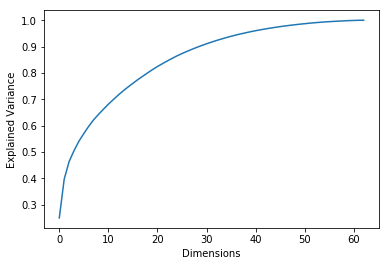

In [36]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(Xcols), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [37]:
N_COMP = 30
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


#### Resultados

In [38]:
PlayerName = 'Emerson - Betis'
NumPlayers = 10

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

df_correlatedPlayers

,PlayerName,Similar Player,Correlation Factor
0,Emerson - Betis,Fabien Centonze - Metz,0.813088
1,Emerson - Betis,Thomas Foket - Reims,0.803293
2,Emerson - Betis,Giovanni Di Lorenzo - Napoli,0.795913
3,Emerson - Betis,Nélson Semedo - Wolves,0.789515
4,Emerson - Betis,Youssouf Sabaly - Bordeaux,0.773687
5,Emerson - Betis,Ruben Aguilar - Monaco,0.768919
6,Emerson - Betis,Stefan Lainer - M'Gladbach,0.758882
7,Emerson - Betis,Luke Ayling - Leeds United,0.749744
8,Emerson - Betis,Javi Galán - Huesca,0.747881
9,Emerson - Betis,Hugo Mallo - Celta Vigo,0.740752


In [39]:
PlayerName = 'Aïssa Mandi - Betis'
NumPlayers = 11

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

df_correlatedPlayers

,PlayerName,Similar Player,Correlation Factor
0,Aïssa Mandi - Betis,Óscar Duarte - Levante,0.803461
1,Aïssa Mandi - Betis,Víctor Ruiz - Betis,0.72057
2,Aïssa Mandi - Betis,Nico Elvedi - M'Gladbach,0.697515
3,Aïssa Mandi - Betis,Marcos Mauro López Gutiérrez - Cádiz,0.682077
4,Aïssa Mandi - Betis,Thiago Silva - Chelsea,0.666752
5,Aïssa Mandi - Betis,Jean-Charles Castelletto - Nantes,0.661139
6,Aïssa Mandi - Betis,Dani Calvo - Elche,0.64872
7,Aïssa Mandi - Betis,Victor Lindelöf - Manchester Utd,0.642583
8,Aïssa Mandi - Betis,Senou Coulibaly - Dijon,0.639684
9,Aïssa Mandi - Betis,Fikayo Tomori - Milan,0.63875


#### Filtrando por equipos parecidos

In [40]:
X, y = dfDFSimTeams[Xcols].iloc[:, 0:len(dfDFSimTeams[Xcols].columns)].values, dfDFSimTeams.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfDFSimTeams[Xcols].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=63, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (224, 63)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.41776675122601514
Explained Variance: 4 components: 0.5222291511580961
Explained Variance: 6 components: 0.5932998216976206
Explained Variance: 8 components: 0.6446681884268776
Explained Variance: 10 components: 0.6863976728728844
Explained Variance: 12 components: 0.7249999692444257
Explained Variance: 14 components: 0.7583186621189644
Explained Variance: 16 components: 0.7876180354069942
Explained Variance: 18 components: 0.8146214867845356
Explained Variance: 20 components: 0.8379409915371925
Explained Variance: 22 components: 0.8598176702862645
Explained Variance: 24 components: 0.8793312223033296
Explained Variance: 26 components: 0.8956846222516404
Explained Variance: 28 components: 0.9106694854851517
Explained Variance: 30 components: 0.9241146802068751
Explained Variance: 32 components: 0.9356194206118923
Explained Variance: 34 components: 0.9460159776212942
Explained Variance: 36 co

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

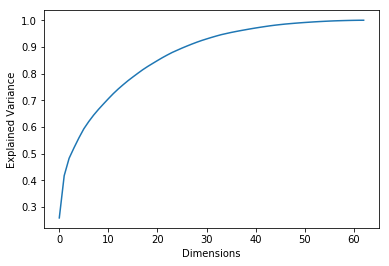

In [41]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(Xcols), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [42]:
N_COMP = 28
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


#### Resultados

In [43]:
PlayerName = 'Emerson - Betis'
NumPlayers = 10

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

df_correlatedPlayers

,PlayerName,Similar Player,Correlation Factor
0,Emerson - Betis,Thomas Foket - Reims,0.841051
1,Emerson - Betis,Joël Veltman - Brighton,0.810004
2,Emerson - Betis,Fabien Centonze - Metz,0.778438
3,Emerson - Betis,Carlos Clerc - Levante,0.70495
4,Emerson - Betis,Matty Cash - Aston Villa,0.667027
5,Emerson - Betis,Kieran Trippier - Atlético Madrid,0.66493
6,Emerson - Betis,Ola Aina - Fulham,0.65768
7,Emerson - Betis,Javi Galán - Huesca,0.654945
8,Emerson - Betis,Andoni Gorosabel - Real Sociedad,0.636276
9,Emerson - Betis,Romain Perraud - Brest,0.632949


In [44]:
PlayerName = 'Aïssa Mandi - Betis'
NumPlayers = 11

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

df_correlatedPlayers

,PlayerName,Similar Player,Correlation Factor
0,Aïssa Mandi - Betis,Óscar Duarte - Levante,0.828363
1,Aïssa Mandi - Betis,Víctor Ruiz - Betis,0.768976
2,Aïssa Mandi - Betis,Jean-Charles Castelletto - Nantes,0.71298
3,Aïssa Mandi - Betis,Senou Coulibaly - Dijon,0.694013
4,Aïssa Mandi - Betis,Igor Zubeldia - Real Sociedad,0.622796
5,Aïssa Mandi - Betis,Stefan Savić - Atlético Madrid,0.601758
6,Aïssa Mandi - Betis,Kevin Akpoguma - Hoffenheim,0.574492
7,Aïssa Mandi - Betis,Yunis Abdelhamid - Reims,0.545761
8,Aïssa Mandi - Betis,Adama Soumaoro - Bologna,0.533775
9,Aïssa Mandi - Betis,Pau Torres - Villarreal,0.522483


## PCA + Clustering

En este apartado, vamos a recomendar un fichaje para la posición de William Carvalho (Medio defensivo) y para la posición de Loren (Delantero centro).

Cómo sabemos, queremos hacer un clustering para analizar qué tipo de jugadores pueden ser interesantes para acometer su fichaje. Y para hacer un clustering y visualizarlo, necesitaremos solo 2 variables.

Para ello, la solución que se nos ha ocurrido es la siguiente:
Vamos a desarrollar un PCA como los anteriores, con las componentes principales necesarias. Una vez desarrollado, haremos una mezcla de las componentes y las juntaremos en 2 componentes. Para poder hacer el clustering. 

De otra manera, si hiciéramos PCA con solo 2 componentes principales, tendríamos información poco fiable, ya que la varianza explicada no llegaría ni al 50%.

Hay que recordar, que el dataset contiene mediocampistas de todo tipo, tanto ofensivos como defensivos. Así que para facilitarle un poco más el trabajo al algoritmo, el dataset con el que vamos a desarrollar el clustering contendrá solamente aquellos jugadores que se parezcan a nuestros jugadores objetivos (William y Loren). Y esto lo haremos mediante las correlaciones, cómo hemos hecho previamente con Emerson y Mandi.

Así pues, seleccionaremos las columnas que formarán parte del dataset de William Carvalho y de Loren, y una vez los tengamos, seguiremos los mismos pasos que hemos seguido con el análisis de los recambios de Emerson y Mandi. Primero sin filtrar equipos, y luego filtrando por equipos parecidos.

### William Carvalho

Antes de nada, hacemos un análisis a simple vista, para ver si encontramos alguna variable que podamos eliminar, según la posición que estamos estudiando. Por ejemplo, los goles o acciones de caire muy ofensivo, las podríamos eliminar, ya que para esta posición, no es lo fundamental, es un 'extra'.

In [45]:
XcolsMF = X2.drop(['Gls', 'Crosses', 'Ast', 'Fld', 'np:G-xG', 'NonPenaltyGoals', 'G/Sh',
'FldToGoal', 'A-xA', 'DribToGoal', 'SoT%', 'G/SoT', 'FldToSh', 'ShToGoalShot'], axis = 1).columns



#### Sin filtrar equipos

In [46]:
X, y = dfMF[XcolsMF].iloc[:, 0:len(dfMF[XcolsMF].columns)].values, dfMF.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfMF[XcolsMF].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=49, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (882, 49)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.4490738357389721
Explained Variance: 4 components: 0.5682679612318613
Explained Variance: 6 components: 0.6285882868615614
Explained Variance: 8 components: 0.6757568221523853
Explained Variance: 10 components: 0.7177913925684022
Explained Variance: 12 components: 0.7556914269704689
Explained Variance: 14 components: 0.789272325242064
Explained Variance: 16 components: 0.8187699339083725
Explained Variance: 18 components: 0.8451655118080601
Explained Variance: 20 components: 0.8672692444575089
Explained Variance: 22 components: 0.8857107581790533
Explained Variance: 24 components: 0.9025835097965355
Explained Variance: 26 components: 0.9183910590214641
Explained Variance: 28 components: 0.9320173433929977
Explained Variance: 30 components: 0.9440343675268001
Explained Variance: 32 components: 0.9548216190863152
Explained Variance: 34 components: 0.9640107522244448
Explained Variance: 36 comp

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

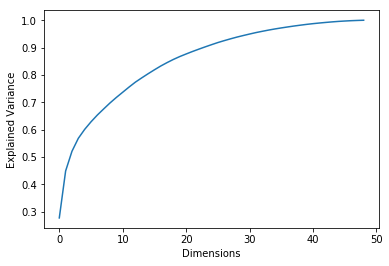

In [47]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(XcolsMF), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [48]:
N_COMP = 24
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


In [49]:
PlayerName = 'William Carvalho - Betis'
NumPlayers = 100

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

SimPlayers = df_correlatedPlayers['Similar Player']

df_correlatedPlayers.head(10)

,PlayerName,Similar Player,Correlation Factor
0,William Carvalho - Betis,Danilo Pereira - Paris S-G,0.863989
1,William Carvalho - Betis,Niccolò Zanellato - Crotone,0.857231
2,William Carvalho - Betis,Nemanja Radoja - Levante,0.853346
3,William Carvalho - Betis,Damien Le Tallec - Montpellier,0.847092
4,William Carvalho - Betis,Francis Coquelin - Villarreal,0.836663
5,William Carvalho - Betis,Pedro Obiang - Sassuolo,0.827637
6,William Carvalho - Betis,Vicente Iborra - Villarreal,0.805698
7,William Carvalho - Betis,Nemanja Matić - Manchester Utd,0.805219
8,William Carvalho - Betis,Mohamed Elneny - Arsenal,0.789026
9,William Carvalho - Betis,Gary Medel - Bologna,0.771882


In [50]:
dfMFClust = df_pca_resultado[df_pca_resultado.index.isin(SimPlayers)].append(df_pca_resultado.loc[df_pca_resultado.index == 'William Carvalho - Betis'])
dfMFClust['V1'] = df_pca_resultado.iloc[:, ::2].sum(axis = 1)
dfMFClust['V2'] = df_pca_resultado.iloc[:, 1::2].sum(axis = 1)
dfMFClust = dfMFClust.drop(dfMFClust.iloc[:, :24], axis = 1)

#### Clustering

Como ocurre en la mayoría de modelos de Machine Learning, por no decir en todos, escalar los datos es un buen paso previo para intentar mejorar los resultados, así que aquí lo haremos.

In [51]:
dfMFClust['V1_std'] = dfMFClust['V1']
dfMFClust['V2_std'] = dfMFClust['V2']

dfMFClust[['V1_std', 'V2_std']] = StandardScaler().fit_transform(dfMFClust[['V1', 'V2']])

<Figure size 1152x576 with 0 Axes>

Text(0.5,0,'V1_std')

Text(0,0.5,'V2_std')

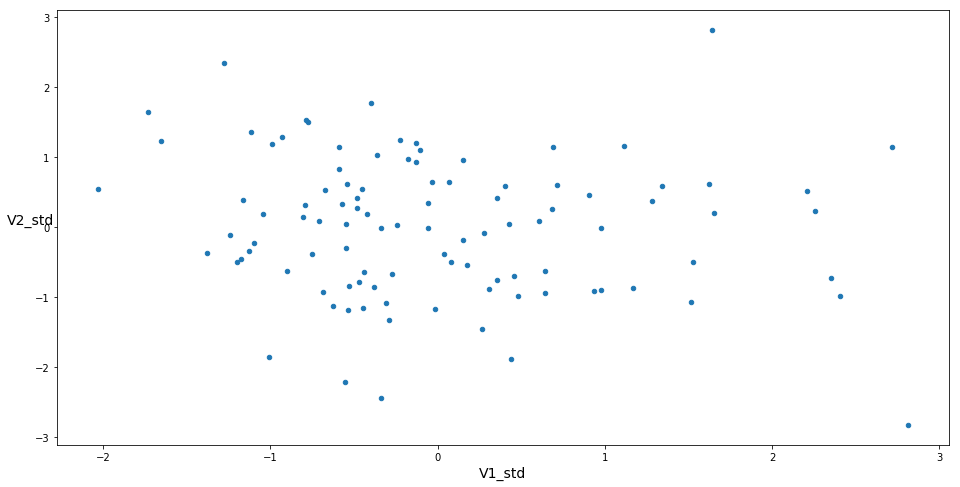

In [52]:
X = dfMFClust[['V1_std', 'V2_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("V1_std", fontsize=14)
plt.ylabel("V2_std", fontsize=14, rotation=0)
plt.show()

Para la elección de los K clusters, seguiremos los mismos pasos que hemos seguido en el clustering de equipos.

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Inertia')

Text(0.5,0.7,'Elbow')

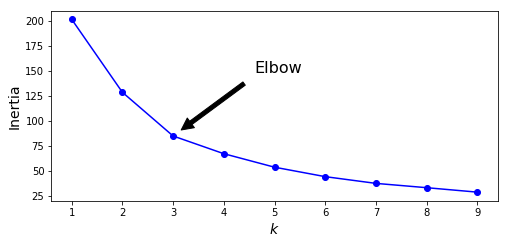

In [53]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.5, 0.7),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

Como vemos, parece que el número óptimo de clusters es 3, según la inercia. Se ve claramente un punto “codo” bien marcado.

<Figure size 576x216 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Silhouette score')

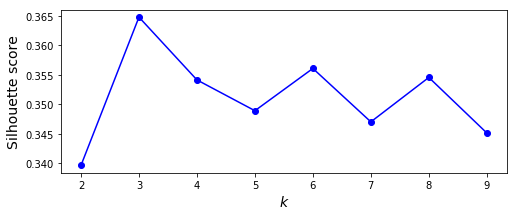

In [54]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

Este gráfico nos reafirma en la idea que el número óptimo de clusters es de 3.

<Figure size 792x648 with 0 Axes>

Text(0.5,1,'$k=2$')

Text(0,0.5,'Cluster')

Text(0.5,1,'$k=3$')

Text(0.5,1,'$k=4$')

Text(0,0.5,'Cluster')

Text(0.5,0,'Silhouette Coefficient')

Text(0.5,1,'$k=5$')

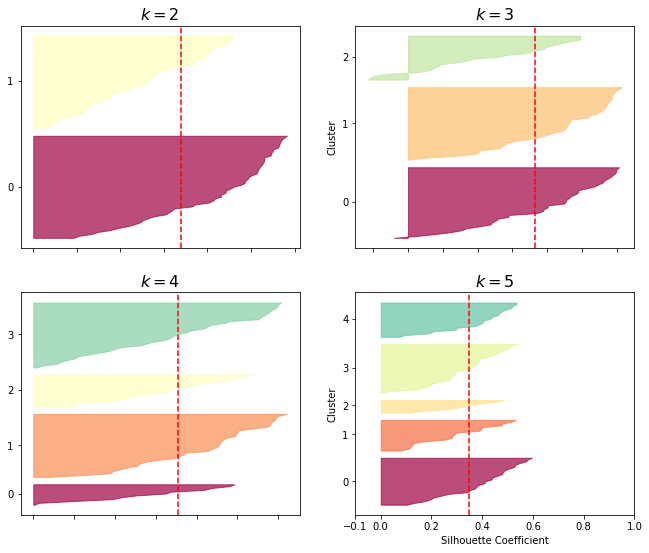

In [55]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Vemos que para 3 clusters hay una buena distribución, hay un poco menos de casos para el cluster 2, pero en general está bien repartido.

Centros de los clusters:  [[-0.29478028 -0.83131657]
 [-0.59790869  0.77568286]
 [ 1.43833707  0.05576658]]


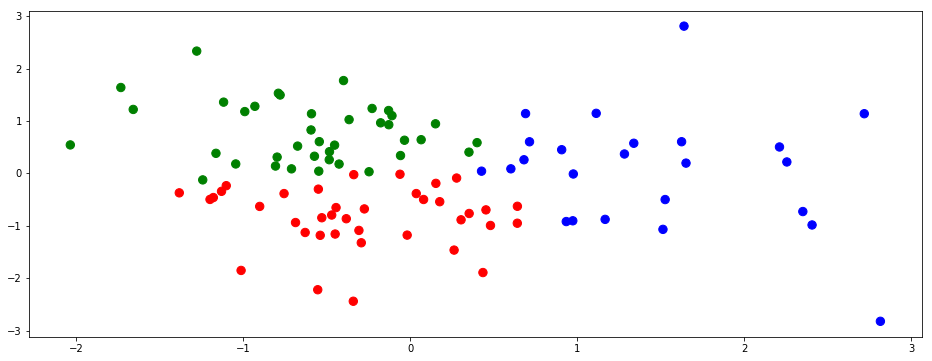

In [56]:
selectedK = 3
dfMFClust['Cluster'] = Exec_KMeans(selectedK, X)


##### Clusters

In [57]:
dfMFClust[dfMFClust['Cluster']==0][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
William Carvalho - Betis,0.336234,-3.629794
Lucas Douath - Saint-Étienne,0.334714,-4.359899
Lucien Agoume - Spezia,-0.186767,-4.456905
Lukas Lerager - Genoa,-0.274674,-3.784737
Damien Le Tallec - Montpellier,-0.333318,-6.486680
Nemanja Radoja - Levante,-0.601234,-3.940224
Luis Milla - Granada,-0.758489,-4.212934
Harry Winks - Tottenham,-0.845123,-2.412042
Niccolò Zanellato - Crotone,-0.893837,-5.518402
Mehdi Bourabia - Sassuolo,-1.173018,-3.432665


In [58]:
dfMFClust[dfMFClust['Cluster']==1][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Zaydou Youssouf - Saint-Étienne,-0.447735,-0.886037
Pedro Obiang - Sassuolo,-0.604910,-1.296166
Miralem Pjanić - Barcelona,-1.255209,-0.073704
Héctor Herrera - Atlético Madrid,-1.534133,-0.759376
Arne Maier - Arminia,-1.857933,-0.782333
Sander Berge - Sheffield Utd,-1.935179,-1.441812
Juan Foyth - Villarreal,-2.101184,0.277681
Fran Beltrán - Celta Vigo,-2.163078,-0.113171
Khéphren Thuram-Ulie - Nice,-2.166616,0.499130
Josuha Guilavogui - Wolfsburg,-2.321374,-0.031357


In [59]:
dfMFClust[dfMFClust['Cluster']==2][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Kevin Möhwald - Werder Bremen,7.391086,-8.588899
Luca Cigarini - Crotone,7.078039,0.361221
Gastón Brugman - Parma,6.063346,-4.435628
Christian Eriksen - Inter,5.883923,-3.856682
Leandro Paredes - Paris S-G,5.573163,-1.718774
Nemanja Gudelj - Sevilla,5.430073,-1.072687
Míchel - Valladolid,3.613512,-1.768364
Arthur Melo - Juventus,3.574635,4.137147
Rober - Levante,3.527635,-0.846325
Ander Guevara - Real Sociedad,3.207983,-3.339464


#### Filtrando equipos parecidos

In [60]:
X, y = dfMFSimTeams[XcolsMF].iloc[:, 0:len(dfMFSimTeams[XcolsMF].columns)].values, dfMFSimTeams.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfMFSimTeams[XcolsMF].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=49, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (241, 49)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.465594971520028
Explained Variance: 4 components: 0.5807677420914202
Explained Variance: 6 components: 0.6422002050796519
Explained Variance: 8 components: 0.6921723752589366
Explained Variance: 10 components: 0.7370711866587605
Explained Variance: 12 components: 0.7754425059553914
Explained Variance: 14 components: 0.8092829663883104
Explained Variance: 16 components: 0.8367466768673599
Explained Variance: 18 components: 0.8613323063074505
Explained Variance: 20 components: 0.8829617296054068
Explained Variance: 22 components: 0.9013780495797862
Explained Variance: 24 components: 0.9174265626583707
Explained Variance: 26 components: 0.9312947468735482
Explained Variance: 28 components: 0.9433885161747694
Explained Variance: 30 components: 0.9539047872637921
Explained Variance: 32 components: 0.9632200049249807
Explained Variance: 34 components: 0.9713406352068016
Explained Variance: 36 comp

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

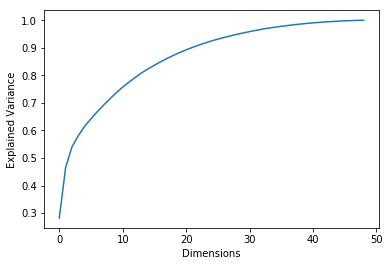

In [61]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(XcolsMF), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [62]:
N_COMP = 22
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


In [63]:
PlayerName = 'William Carvalho - Betis'
NumPlayers = 50

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

SimPlayers = df_correlatedPlayers['Similar Player']


df_correlatedPlayers.head(10)

,PlayerName,Similar Player,Correlation Factor
0,William Carvalho - Betis,Nemanja Radoja - Levante,0.831969
1,William Carvalho - Betis,Francis Coquelin - Villarreal,0.829255
2,William Carvalho - Betis,Vicente Iborra - Villarreal,0.813404
3,William Carvalho - Betis,Gary Medel - Bologna,0.796022
4,William Carvalho - Betis,Mohamed Elneny - Arsenal,0.757655
5,William Carvalho - Betis,Alessandro Deiola - Cagliari,0.733178
6,William Carvalho - Betis,Rober - Levante,0.725878
7,William Carvalho - Betis,Jordan Marié - Dijon,0.705308
8,William Carvalho - Betis,Sidy Sarr - Nîmes,0.703484
9,William Carvalho - Betis,Lucien Agoume - Spezia,0.702821


In [64]:
dfMFClust = df_pca_resultado[df_pca_resultado.index.isin(SimPlayers)].append(df_pca_resultado.loc[df_pca_resultado.index == 'William Carvalho - Betis'])
dfMFClust['V1'] = df_pca_resultado.iloc[:, ::2].sum(axis = 1)
dfMFClust['V2'] = df_pca_resultado.iloc[:, 1::2].sum(axis = 1)
dfMFClust = dfMFClust.drop(dfMFClust.iloc[:, :22], axis = 1)

#### Clustering

In [65]:
dfMFClust['V1_std'] = dfMFClust['V1']
dfMFClust['V2_std'] = dfMFClust['V2']

dfMFClust[['V1_std', 'V2_std']] = StandardScaler().fit_transform(dfMFClust[['V1', 'V2']])

<Figure size 1152x576 with 0 Axes>

Text(0.5,0,'V1_std')

Text(0,0.5,'V2_std')

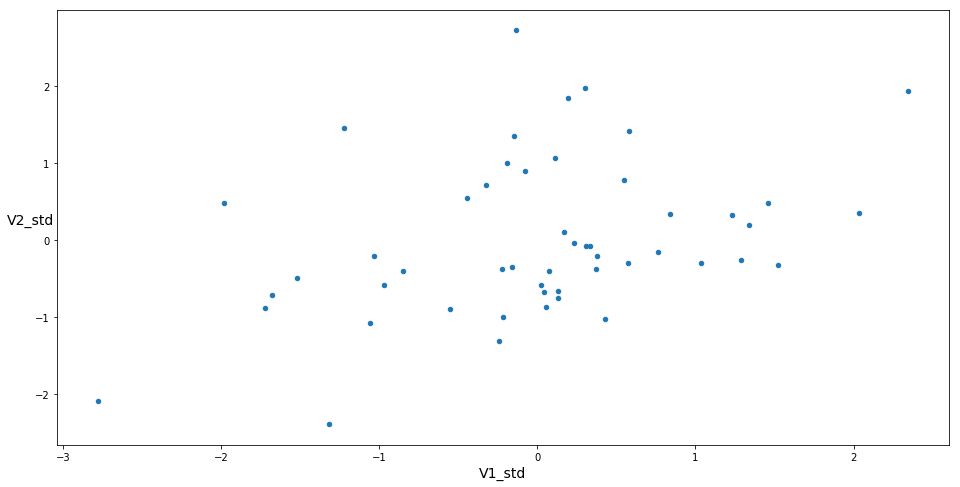

In [66]:
X = dfMFClust[['V1_std', 'V2_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("V1_std", fontsize=14)
plt.ylabel("V2_std", fontsize=14, rotation=0)
plt.show()

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Inertia')

Text(0.5,0.7,'Elbow')

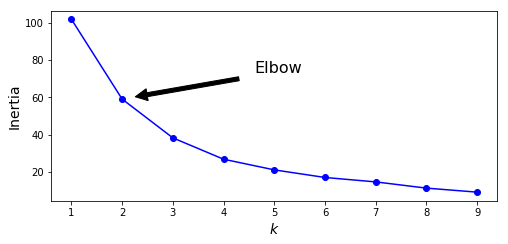

In [67]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.5, 0.7),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

En este caso parece que tenemos un punto "codo" en k = 2. Vemos qué sucede si nos fijamos en los silhouettes scores.

<Figure size 576x216 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Silhouette score')

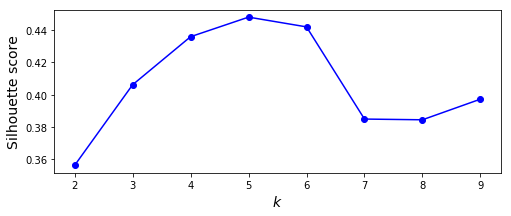

In [68]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

<Figure size 792x648 with 0 Axes>

Text(0.5,1,'$k=2$')

Text(0,0.5,'Cluster')

Text(0.5,1,'$k=3$')

Text(0.5,1,'$k=4$')

Text(0,0.5,'Cluster')

Text(0.5,0,'Silhouette Coefficient')

Text(0.5,1,'$k=5$')

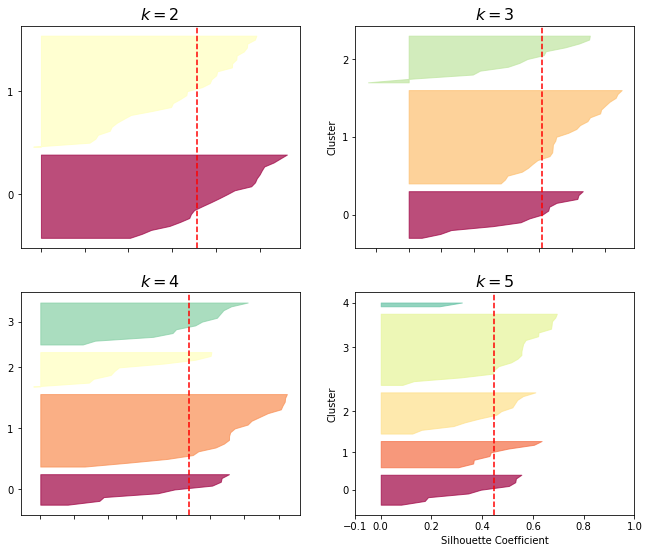

In [69]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Vemos que con 5 grupos, no logramos una buena distribución, y con 4 parece que lso resultados mejoran. Vamos a escoger 4 grupos, ya que por distribución, silhouettes scores e inercia, parece lo más óptimo entre los candidatos.

Centros de los clusters:  [[ 1.45530677  0.30235615]
 [ 0.13096953 -0.50314321]
 [-1.49034402 -0.83788864]
 [-0.06780928  1.31004544]]


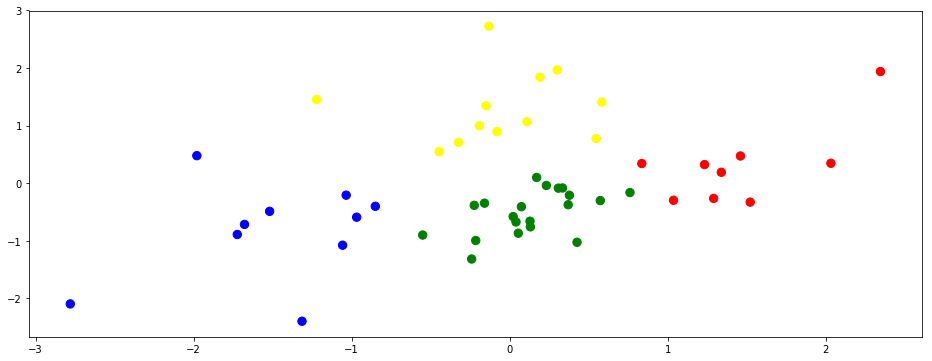

In [70]:
selectedK = 4
dfMFClust['Cluster'] = Exec_KMeans(selectedK, X)


Vemos 4 grupos bien diferenciados según la posición respecto al eje. El grupo rojo y azul son los extremos del eje X, mientras que el grupo verde y amarillo se diferencian según su posición respecto al eje Y.

##### Clusters

In [71]:
dfMFClust[dfMFClust['Cluster']==0][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Martín Zubimendi - Real Sociedad,4.696586,6.947344
Gastón Brugman - Parma,3.763078,3.244698
Alessandro Deiola - Cagliari,2.242131,1.676356
Wesley Lautoa - Dijon,2.058406,3.538766
Fabian Kunze - Arminia,1.697989,2.881552
Andrés Guardado - Betis,1.553459,1.826288
Unai Vencedor Paris - Athletic Club,1.381125,3.191608
Unai López - Athletic Club,0.797649,1.751686
Alfred Duncan - Cagliari,0.199532,3.234339


In [72]:
dfMFClust[dfMFClust['Cluster']==1][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Sidy Sarr - Nîmes,-0.022847,2.063148
Lucien Agoume - Spezia,-0.582914,1.737869
Lucas Torreira - Atlético Madrid,-1.021174,0.054908
Hianga Mananga Mbock - Brest,-1.164905,1.953659
Marko Rog - Cagliari,-1.187507,1.571583
William Carvalho - Betis,-1.294227,2.246864
Nemanja Radoja - Levante,-1.372827,2.241226
Nicolás Domínguez - Bologna,-1.598855,2.348336
Léo Sena - Spezia,-1.781922,2.672665
Hugo Magnetti - Brest,-1.899870,0.678033


In [73]:
dfMFClust[dfMFClust['Cluster']==2][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Victorien Angban - Metz,-4.822225,1.507828
Rober - Levante,-5.174185,1.067673
Mohamed Elneny - Arsenal,-5.372007,1.956792
Tom Davies - Everton,-5.439033,-0.062244
Steven Alzate - Brighton,-6.203995,-3.132617
Idrissa Doumbia - Huesca,-6.813833,1.304329
Yannick Cahuzac - Lens,-7.287769,0.776156
Borja García - Huesca,-7.423866,0.370198
Mamadou Fofana - Metz,-8.185742,3.551712
Josh Maja - Fulham,-10.570993,-2.434006


In [74]:
dfMFClust[dfMFClust['Cluster']==3][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Ander Guevara - Real Sociedad,-0.555543,5.713241
Héctor Herrera - Atlético Madrid,-0.660630,4.241162
Étienne Capoue - Villarreal,-1.396573,7.011402
Paul Lasne - Brest,-1.719355,6.719748
Thomas Partey - Arsenal,-1.965565,4.924177
Vincent Pajot - Metz,-2.531124,4.519464
Juan Foyth - Villarreal,-2.682914,8.777821
Nikola Vukčević - Levante,-2.735036,5.566439
Francis Coquelin - Villarreal,-2.861837,4.760833
Vicente Iborra - Villarreal,-3.255766,4.089849


### Loren

#### Sin filtrar equipos

In [75]:
X, y = dfFW[Xcols].iloc[:, 0:len(dfFW[Xcols].columns)].values, dfFW.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfFW[Xcols].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=63, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (656, 63)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.40147726260132555
Explained Variance: 4 components: 0.509020529563316
Explained Variance: 6 components: 0.5780602068461536
Explained Variance: 8 components: 0.6297069614280916
Explained Variance: 10 components: 0.6737782783963879
Explained Variance: 12 components: 0.7114701877197729
Explained Variance: 14 components: 0.7452643099798886
Explained Variance: 16 components: 0.776345834639312
Explained Variance: 18 components: 0.805606721041029
Explained Variance: 20 components: 0.8308312416669045
Explained Variance: 22 components: 0.8535609428962794
Explained Variance: 24 components: 0.8727660151601225
Explained Variance: 26 components: 0.8898742687568589
Explained Variance: 28 components: 0.9041261676769866
Explained Variance: 30 components: 0.9169049115236937
Explained Variance: 32 components: 0.9279435867750676
Explained Variance: 34 components: 0.9380537411260859
Explained Variance: 36 compo

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

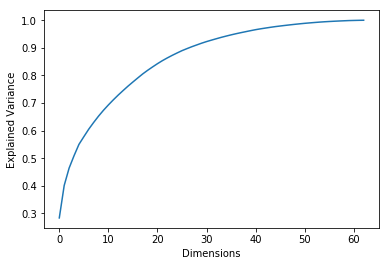

In [76]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(Xcols), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [77]:
N_COMP = 28
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


In [78]:
PlayerName = 'Loren Morón - Betis'
NumPlayers = 100

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

SimPlayers = df_correlatedPlayers['Similar Player']


df_correlatedPlayers.head(10)

,PlayerName,Similar Player,Correlation Factor
0,Loren Morón - Betis,Kenan Kodro - Valladolid,0.846996
1,Loren Morón - Betis,Emmanuel Rivière - Crotone,0.779859
2,Loren Morón - Betis,Aboubakar Kamara - Dijon,0.773402
3,Loren Morón - Betis,Shinji Okazaki - Huesca,0.76827
4,Loren Morón - Betis,Nicolás González - Stuttgart,0.767807
5,Loren Morón - Betis,Rhian Brewster - Sheffield Utd,0.759766
6,Loren Morón - Betis,Vedat Muriqi - Lazio,0.757517
7,Loren Morón - Betis,Mariano - Real Madrid,0.746503
8,Loren Morón - Betis,Ishak Belfodil - Hoffenheim,0.738449
9,Loren Morón - Betis,Sebastian Andersson - Köln,0.731604


In [79]:
dfFWClust = df_pca_resultado[df_pca_resultado.index.isin(SimPlayers)].append(df_pca_resultado.loc[df_pca_resultado.index == 'Loren Morón - Betis'])
dfFWClust['V1'] = df_pca_resultado.iloc[:, ::2].sum(axis = 1)
dfFWClust['V2'] = df_pca_resultado.iloc[:, 1::2].sum(axis = 1)
dfFWClust = dfFWClust.drop(dfFWClust.iloc[:, :28], axis = 1)

#### Clustering

Como ocurre en la mayoría de modelos de Machine Learning, por no decir en todos, escalar los datos es un buen paso previo para intentar mejorar los resultados, así que aquí lo haremos.

In [80]:
dfFWClust['V1_std'] = dfFWClust['V1']
dfFWClust['V2_std'] = dfFWClust['V2']

dfFWClust[['V1_std', 'V2_std']] = StandardScaler().fit_transform(dfFWClust[['V1', 'V2']])

<Figure size 1152x576 with 0 Axes>

Text(0.5,0,'V1_std')

Text(0,0.5,'V2_std')

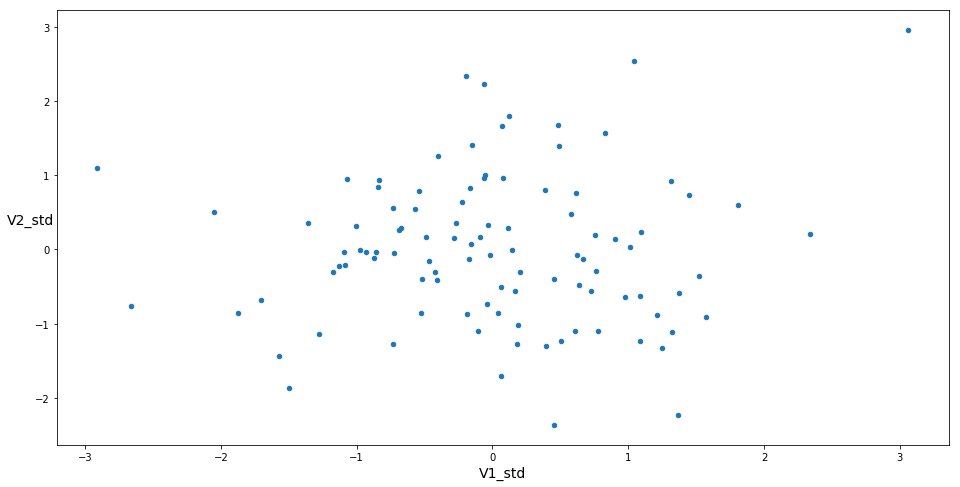

In [81]:
X = dfFWClust[['V1_std', 'V2_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("V1_std", fontsize=14)
plt.ylabel("V2_std", fontsize=14, rotation=0)
plt.show()

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Inertia')

Text(0.5,0.7,'Elbow')

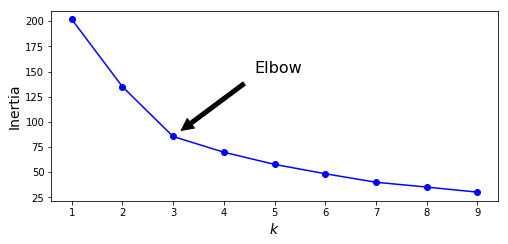

In [82]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.5, 0.7),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Silhouette score')

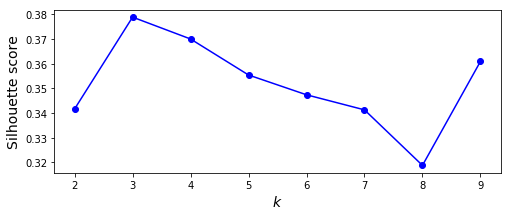

In [83]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

<Figure size 792x648 with 0 Axes>

Text(0.5,1,'$k=2$')

Text(0,0.5,'Cluster')

Text(0.5,1,'$k=3$')

Text(0.5,1,'$k=4$')

Text(0,0.5,'Cluster')

Text(0.5,0,'Silhouette Coefficient')

Text(0.5,1,'$k=5$')

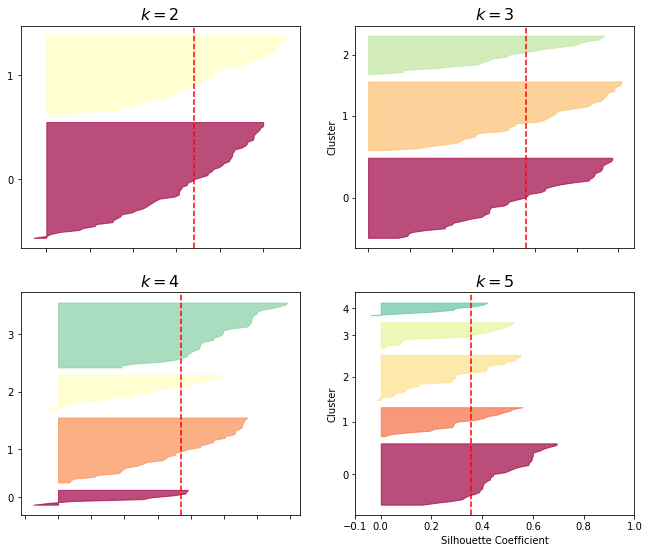

In [84]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Centros de los clusters:  [[-0.87018445 -0.04074174]
 [ 0.7078881  -0.73154839]
 [ 0.53457483  1.37234214]]


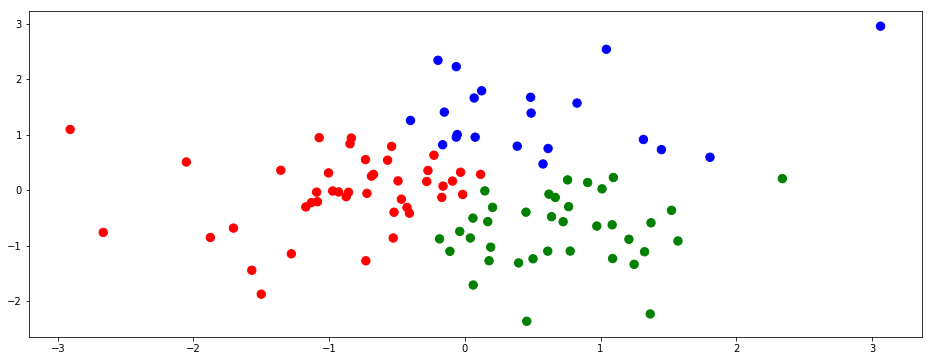

In [85]:
selectedK = 3
dfFWClust['Cluster'] = Exec_KMeans(selectedK, X)


##### Clusters

In [86]:
dfFWClust[dfFWClust['Cluster']==0][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Emmanuel Rivière - Crotone,-5.578829,1.470346
Moussa Dembélé - Lyon,-5.960241,0.430132
Ishak Belfodil - Hoffenheim,-6.004033,1.579275
Yoshinori Mutō - Eibar,-6.177216,1.122616
Valentin Mihaila - Parma,-6.378533,0.862675
Oliver Burke - Sheffield Utd,-6.404081,0.276755
Ángel Rodríguez - Getafe,-6.571594,2.460273
Nikola Kalinić - Hellas Verona,-6.698986,1.669284
Dereck Kutesa - Reims,-6.725293,1.099094
Thierry Ambrose - Metz,-7.094018,-0.541276


In [87]:
dfFWClust[dfFWClust['Cluster']==1][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Simone Zaza - Torino,0.845034,1.249580
Aaron Leya Iseka - Metz,-1.377815,-1.978661
Trézéguet - Aston Villa,-1.515497,-0.392568
Graziano Pellè - Parma,-1.951806,-1.039186
Miguel Baeza - Celta Vigo,-1.967726,-5.756027
Olivier Giroud - Chelsea,-2.088126,-2.535772
Islam Slimani - Lyon,-2.309616,-3.187588
Martinelli - Arsenal,-2.421158,-1.889776
Josh Maja - Bordeaux,-2.752739,1.306426
Borja Valero - Fiorentina,-2.768588,-2.887266


In [88]:
dfFWClust[dfFWClust['Cluster']==2][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Raúl Jiménez - Wolves,2.934841,9.139511
Willian José - Wolves,-0.695447,2.354296
Moussa Konaté - Dijon,-1.729798,2.748974
Michy Batshuayi - Crystal Palace,-2.112694,3.274662
Dani Gómez - Levante,-2.901472,7.944198
Klaas-Jan Huntelaar - Schalke 04,-3.525879,5.159653
Ilija Nestorovski - Udinese,-4.142172,2.808953
Adolfo Gaich - Benevento,-4.249108,2.006269
Dan Ndoye - Nice,-4.502853,4.640588
Nassim Boujellab - Schalke 04,-4.513692,5.460178


#### Filtrando equipos parecidos

In [89]:
X, y = dfFWSimTeams[Xcols].iloc[:, 0:len(dfFWSimTeams[Xcols].columns)].values, dfFWSimTeams.iloc[:, 0].values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = len(dfFWSimTeams[Xcols].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=63, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Shape x_PCA:  (180, 63)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.4277197100218809
Explained Variance: 4 components: 0.5336935890414979
Explained Variance: 6 components: 0.6069717815760884
Explained Variance: 8 components: 0.6644229166603858
Explained Variance: 10 components: 0.7101024027418851
Explained Variance: 12 components: 0.7498976411636737
Explained Variance: 14 components: 0.7858213869692904
Explained Variance: 16 components: 0.8158817627623633
Explained Variance: 18 components: 0.8413069587333126
Explained Variance: 20 components: 0.8632848951061065
Explained Variance: 22 components: 0.8819824204954309
Explained Variance: 24 components: 0.8975488705311923
Explained Variance: 26 components: 0.9118033000498392
Explained Variance: 28 components: 0.9245150202382955
Explained Variance: 30 components: 0.9360514553396927
Explained Variance: 32 components: 0.9458502014367259
Explained Variance: 34 components: 0.9540167173885844
Explained Variance: 36 com

Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

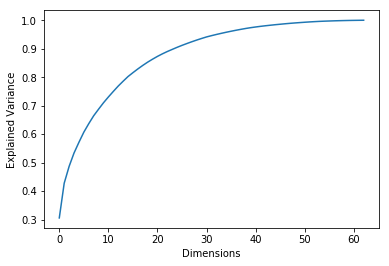

In [90]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(Xcols), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [91]:
N_COMP = 24
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

corr_matrix = df_pca_resultado.T.corr(method='pearson')


In [92]:
PlayerName = 'Loren Morón - Betis'
NumPlayers = 50

df_correlatedPlayers = GetSimilarPlayers(PlayerName, NumPlayers, corr_matrix)

SimPlayers = df_correlatedPlayers['Similar Player']

df_correlatedPlayers.head(10)

,PlayerName,Similar Player,Correlation Factor
0,Loren Morón - Betis,Shinji Okazaki - Huesca,0.793081
1,Loren Morón - Betis,Aboubakar Kamara - Dijon,0.781998
2,Loren Morón - Betis,Sergio León - Levante,0.767441
3,Loren Morón - Betis,Vagner Gonçalves - Metz,0.742901
4,Loren Morón - Betis,Sergio Córdova - Arminia,0.740643
5,Loren Morón - Betis,Ishak Belfodil - Hoffenheim,0.733438
6,Loren Morón - Betis,Kaj Sierhuis - Reims,0.705406
7,Loren Morón - Betis,Sven Schipplock - Arminia,0.704427
8,Loren Morón - Betis,Kevin Denkey - Nîmes,0.6909
9,Loren Morón - Betis,Graziano Pellè - Parma,0.663452


In [93]:
dfFWClust = df_pca_resultado[df_pca_resultado.index.isin(SimPlayers)].append(df_pca_resultado.loc[df_pca_resultado.index == 'Loren Morón - Betis'])
dfFWClust['V1'] = df_pca_resultado.iloc[:, ::2].sum(axis = 1)
dfFWClust['V2'] = df_pca_resultado.iloc[:, 1::2].sum(axis = 1)
dfFWClust = dfFWClust.drop(dfFWClust.iloc[:, :22], axis = 1)

#### Clustering

In [94]:
dfFWClust['V1_std'] = dfFWClust['V1']
dfFWClust['V2_std'] = dfFWClust['V2']

dfFWClust[['V1_std', 'V2_std']] = StandardScaler().fit_transform(dfFWClust[['V1', 'V2']])

<Figure size 1152x576 with 0 Axes>

Text(0.5,0,'V1_std')

Text(0,0.5,'V2_std')

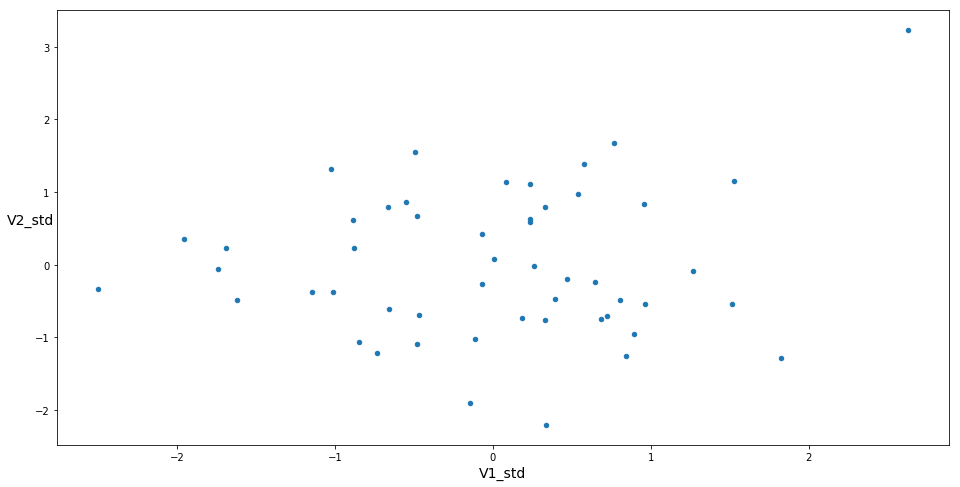

In [95]:
X = dfFWClust[['V1_std', 'V2_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("V1_std", fontsize=14)
plt.ylabel("V2_std", fontsize=14, rotation=0)
plt.show()

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Inertia')

Text(0.5,0.7,'Elbow')

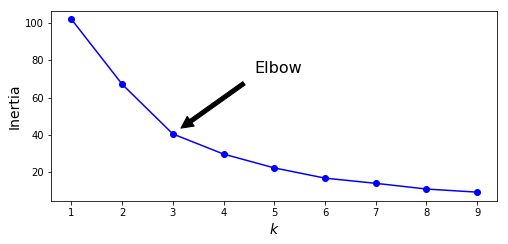

In [96]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.5, 0.7),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Silhouette score')

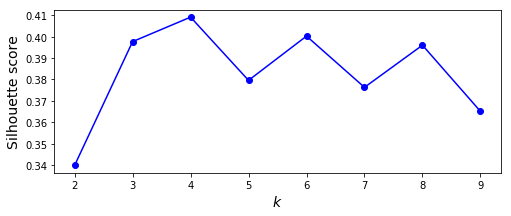

In [97]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

<Figure size 792x648 with 0 Axes>

Text(0.5,1,'$k=2$')

Text(0,0.5,'Cluster')

Text(0.5,1,'$k=3$')

Text(0.5,1,'$k=4$')

Text(0,0.5,'Cluster')

Text(0.5,0,'Silhouette Coefficient')

Text(0.5,1,'$k=5$')

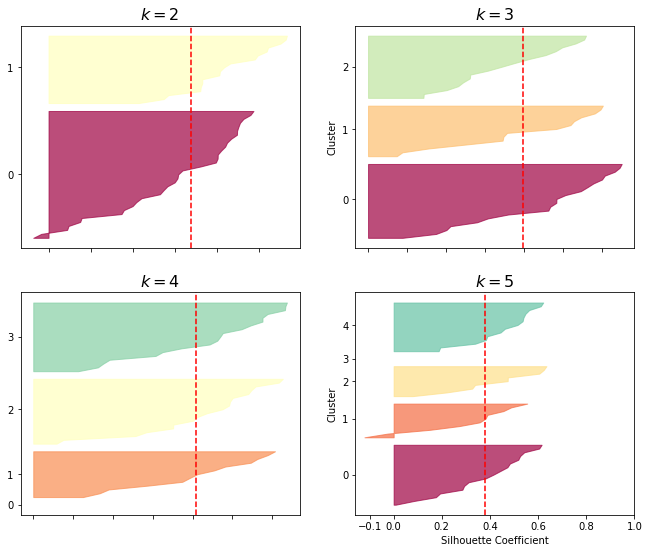

In [98]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Centros de los clusters:  [[ 0.59030824 -0.71375776]
 [-1.18756512 -0.34765715]
 [ 0.28351453  1.12602091]]


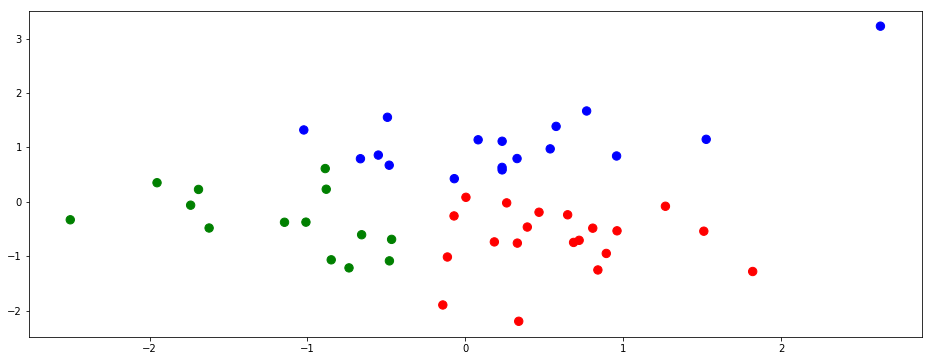

In [99]:
selectedK = 3
dfFWClust['Cluster'] = Exec_KMeans(selectedK, X)


##### Clusters

In [100]:
dfFWClust[dfFWClust['Cluster']==0][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Mihai Dobre - Dijon,4.123362,-4.575785
Sven Schipplock - Arminia,3.013917,-2.064467
Dani Gómez - Levante,2.142301,-0.510357
Loren Morón - Betis,1.043515,-2.041017
Thierry Ambrose - Metz,0.799694,-3.450399
Martín Merquelanz - Real Sociedad,0.608897,-4.479841
Trézéguet - Aston Villa,0.492485,-1.876059
Javairô Dilrosun - Hertha BSC,0.183842,-2.633001
Dereck Kutesa - Reims,0.057197,-2.764140
Sergio Córdova - Arminia,-0.077473,-1.042544


In [101]:
dfFWClust[dfFWClust['Cluster']==1][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Vagner Gonçalves - Metz,-4.074356,-2.574074
Alexis Mac Allister - Brighton,-4.123917,-3.913493
Roberto López - Real Sociedad,-4.754711,-2.285223
Rodrigo - Betis,-5.041187,-4.350017
Sergio León - Levante,-5.445047,-3.847685
Valentin Mihaila - Parma,-5.558072,0.550499
Mathew Leckie - Hertha BSC,-5.580912,1.838399
Martinelli - Arsenal,-6.019173,-1.500386
Reinhold Yabo - Arminia,-6.505542,-1.508613
Juan Brunetta - Parma,-8.217121,-1.865809


In [102]:
dfFWClust[dfFWClust['Cluster']==2][['V1', 'V2']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2
Leonardo Pavoletti - Cagliari,7.023590,10.710349
Asier Villalibre - Athletic Club,3.068152,3.660325
Sargis Adamyan - Hoffenheim,1.033197,2.621266
Graziano Pellè - Parma,0.353367,5.425228
Moussa Konaté - Dijon,-0.339390,4.466168
Kalifa Coulibaly - Nantes,-0.473350,3.065369
Jérémy Le Douaron - Brest,-1.226096,2.462462
Borja Iglesias - Betis,-1.564611,3.539237
Roberto Inglese - Parma,-1.564660,1.755928
Roger Assalé - Dijon,-1.566285,1.911044
